# Add Vectors to `FeedbackDataset`

This tutorial is part of a series in which we will get to know the `FeedbackDataset`. In this step, we will show how to set the vector settings and add the vectors, which allow the similarity search in the UI and PythonSDK. You can also take a look at our previous tutorials for [configuring the users and workspaces](./configure-users-and-workspaces-000.ipynb) and [creating a dataset](./create-dataset-001.ipynb) for a comprehensive overview of the complete workflow. Feel free to check out the [practical guides](../../../../practical_guides/practical_guides.md) page for more in-depth information and the [semantic search](../../../../practical_guides/annotation_workflows/semantic_search.md) page for more information about the similarity search.

Vectors are the embeddings of the text pieces created by a language model. By means of embeddings, we can mathematically represent the text pieces in a vector space. As a result of this representation, we can calculate how similar or different two or more text pieces are. Argilla offers a great opportunity to use this similarity search in the UI and PythonSDK. If you want to see a comprehensive overview of embeddings, you can refer to [this page](https://www.turing.com/kb/guide-on-word-embeddings-in-nlp).

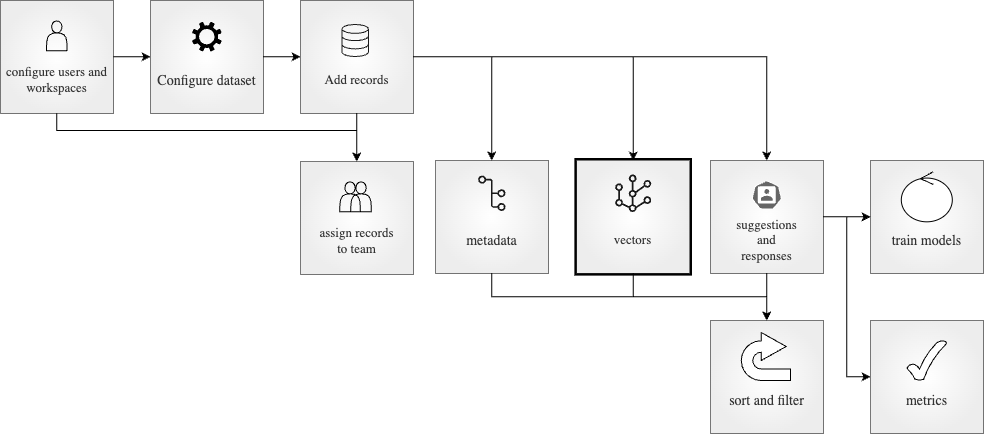

## Table of Contents

1. [Pull the Dataset](#Pull-the-Dataset)
    1. [From Argilla](#From-Argilla)
    2. [From HuggingFace Hub](#From-HuggingFace-Hub)
2. [Add Vector Settings](#Add-Vector-Settings)
3. [Add Vectors](#Add-Vectors)
    1. [To local FeedbackDataset](#To-local-FeedbackDataset)
    2. [To RemoteFeedbackDataset](#To-RemoteFeedbackDataset)
4. [Find Similar Records](#Find-Similar-Records)
5. [Push the Dataset](#Push-the-Dataset)
    1. [To Argilla](#To-Argilla)
    2. [To HuggingFace Hub](#To-HuggingFace-Hub)
6. [Conclusion](#Conclusion)

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:

**Deploy Argilla on Hugging Face Spaces:** If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/new-space?template=argilla/argilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).

**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](../../../../getting_started/quickstart.md). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip

This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter notebook tool of your choice.
</div>

First, let's install our dependencies and import the necessary libraries:

In [ ]:
!pip install argilla
!pip install datasets

In [1]:
import argilla as rg
from argilla._constants import DEFAULT_API_KEY
from sentence_transformers import SentenceTransformer

In order to run this notebook we will need some credentials to push and load datasets from `Argilla` and 🤗`hub`, let's set them in the following cell:

In [2]:
# Argilla credentials
api_url = "http://localhost:6900" # "https://<YOUR-HF-SPACE>.hf.space"
api_key = DEFAULT_API_KEY # admin.apikey
# Huggingface credentials
hf_token = "hf_..."

Log to argilla:

In [ ]:
rg.init(
    api_url=api_url,
    api_key=api_key
)

### Enable Telemetry

We gain valuable insights from how you interact with our tutorials. To improve ourselves in offering you the most suitable content, using the following lines of code will help us understand that this tutorial is serving you effectively. Though this is entirely anonymous, you can choose to skip this step if you prefer. For more info, please check out the [Telemetry](../../reference/telemetry.md) page.

In [ ]:
from argilla.utils.telemetry import tutorial_running

tutorial_running()

## Pull the Dataset

As we uploaded the dataset we created in the [previous tutorial](./create-dataset-001.ipynb) to both Argilla and HuggingFace Hub, we can pull the dataset from either of them. Let us see how we can pull the dataset from both.

### From Argilla

We can pull the dataset from Argilla by using the `from_argilla` method. 

In [ ]:
dataset = rg.FeedbackDataset.from_argilla("end2end_textclassification")

### From HuggingFace Hub

We can also pull the dataset from HuggingFace Hub. Similarly, we can use the `from_huggingface` method to pull the dataset.

In [ ]:
dataset = rg.FeedbackDataset.from_huggingface("argilla/end2end_textclassification")

<div class="alert alert-info">

Note 

The dataset pulled from HuggingFace Hub is an instance of `FeedbackDataset` whereas the dataset pulled from Argilla is an instance of `RemoteFeedbackDataset`. The difference between the two is that the former is a local one and the changes made on it stay locally. On the other hand, the latter is a remote one and the changes made on it are directly reflected on the dataset on the Argilla server, which can make your process faster.

</div>

Let us briefly examine what our dataset looks like. It is a dataset that consists of data items with the field `text` that is yet to be annotated.

In [3]:
dataset[0].fields

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."}

## Add Vector Settings

As the first step of adding vectors, we need to add the vector settings to the dataset. This way, we will be able to access a particular vector setting both from the UI and PythonSDK. Whether you work with a local dataset or a remote dataset, the process is the same. Let us first create the vector setting.

In [4]:
vector_settings = rg.VectorSettings(
    name="sentence_embedding",
    title="Sentence Embedding",
    dimensions=384
)

In vector settings, `name` will be the name shown in the records and we will access each vector setting by its name. `title` will be the name shown in the UI. And `dimension` will define how many dimensions each vector will have. This number must be equal to the number of dimensions of the vectors, otherwise, an error will be raised. We set it to 384 as the model we will use in later steps has 384 dimensions.

In [ ]:
dataset.add_vector_settings(vector_settings)

## Add Vectors

Now that we make sure that our dataset has the vector settings, we can move on to adding the vectors to each record. First, we will need a tool to create the embeddings of the text items so that we can have the vectors. In this tutorial, we will use the [paraphrase-MiniLM-L3-v2](https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L3-v2) model to create the embeddings. You can use any model of your choice. Please make sure that the dimensionality of the model you use is the same as the dimensionality of the vector setting you created.

Let us first load the model.

In [6]:
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

And test the encoded vectors on a sample text to make sure that the dimensionality is correct.

In [7]:
sentence = "Argentina and Uruguay are South American countries."
len(model.encode(sentence))

384

As our model is ready to create the embeddings, we can now create vectors for each record in the dataset. The process of adding vectors is just slightly different for local `FeedbackDataset` and `RemoteFeedbackDataset`. We will see how to add vectors to both.

### To local `FeedbackDataset`

To add vectors to a local `FeedbackDataset`, we will iterate over the records we have in the dataset. For each record, we encode it with the sentence transformers model and we assign the encoded vector to the `vector` field of the record. 

In [8]:
for record in dataset.records:
    record.vectors["sentence_embedding"] = model.encode(record.fields["text"]).tolist()

Please note that the vector you will add should be a list of float values. If you have a numpy array, you can convert it to a list by using the `tolist()` method, as we did in the previous cell.

### To `RemoteFeedbackDataset`

To add vectors to a `RemoteFeedbackDataset`, we first need to create a list of the records we have in the dataset. We will make the changes on this list similar to what we did for the local dataset. Then, with the `update_records` method, we will update the records in the dataset on the Argilla server.

In [9]:
modified_records = [record for record in dataset.records]

for record in modified_records:
    record.vectors["sentence_embedding"] = model.encode(record.fields["text"]).tolist()

And, let us update the records.

In [ ]:
dataset.update_records(modified_records)

## Find Similar Records

Now that we have the vectors for each record, let us see the semantic search in action. We can accomplish this via both the UI and PythonSDK. To find similar records in the UI, please refer to the [push the dataset](#Push-the-Dataset) section, where we upload the improved dataset to Argilla server and easily do semantic search. In this section, we will see how to do it within the PythonSDK.

To find similar records, we will use the `find_similar_records` method. We need to feed this method with the vector name we want to use for the search. For the particular vector, we have two options: we can either use a record by the `record` parameter or we can define a new vector by the `vector` parameter. You can limit the number of records you want to get by the `max_results` parameter. 

In [11]:
similar_records = dataset.find_similar_records(
    vector_name="sentence_embedding",
    record=dataset[0],
    max_results=5
)

The `similar_records` object we created contains the 5 top records similar to the first record in the dataset. Let us see what these records are.

In [12]:
[record[0].fields["text"] for record in similar_records]

["Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.",
 "Strategies for a Sideways Market (Reuters) Reuters - The bulls and the bears are in this\\together, scratching their heads and wondering what's going to\\happen next.",
 "Strategies for a Sideways Market  WASHINGTON (Reuters) - The bulls and the bears are in this  together, scratching their heads and wondering what's going to  happen next.",
 'Wall Street to Open Little Changed  NEW YORK (Reuters) - Wall Street is seen opening little  changed on Monday as crude prices remain high, but insurers may  dip on worries about their potential liabilities after a  hurricane struck Florida on Friday.',
 "Chrysler's Bling King After a tough year, Detroit's troubled carmaker is back -- thanks to a maverick designer and a car that is dazzling the hip-hop crowd"]

On the other hand, we can feed the `find_similar_records` method with a vector we define. Let us first create an embedding with the sentence transformers model and then find the records similar to this vector.

In [13]:
text = "Baseball: Smoltz sizzles as Braves force deciding game HOUSTON, United States : JD Drew singled to drive in a run in the top of the ninth inning and lift the Atlanta Braves to a 6-5 win over Houston and force the Astros into a fifth and deciding game."

text_vector = model.encode(text).tolist()

similar_records = dataset.find_similar_records(
    vector_name="sentence_embedding",
    value=text_vector,
    max_results=5
)

We can see the ids of the records that are similar to the vector we defined.

In [14]:
[record[0].external_id for record in similar_records]

['record-746', 'record-459', 'record-642', 'record-716', 'record-643']

## Push the Dataset

The dataset now has the vector settings and each record is assigned a vector. We can do semantic search in the UI by pushing the dataset to the Argilla server. We can also push the dataset to HuggingFace Hub to use it in other projects. Let us see how we can push the dataset to both. Note that you do not need to push the dataset if you have opted for pulling the dataset from Argilla server. Since it is a `RemoteFeedbackDataset`, the changes you make on it are directly reflected on the dataset on the Argilla server.

### To Argilla

If you have opted to pull the dataset from HuggingFace and want to push to Argilla, you can simply use the `push_to_argilla` method.

In [ ]:
remote_dataset = dataset.push_to_argilla("end2end_textclassification_with_vectors")

![workflow](../../../../_static/tutorials/end2end/text-classification/argilla-annotation-ui-vectors.png)

Now, it is possible to do semantic search in the UI. As you can see above, you need to click the `Find Similar` button on the right top of the record to see similar records. You have the opportunity to limit the number of results as well as define your research as the most or least similar records. You can also see the similarity score of each record to the record you are searching for.

### To HuggingFace Hub

You can push the dataset to HuggingFace Hub by using the `push_to_huggingface` method. Do not forget to create a model card as well, which will make the dataset more readable and understandable for the users.

To be able to upload your dataset to the Hub, you must be logged in to the Hub. The following cell will log us with our previous token.

If we don't have one already, we can obtain it from [here](https://huggingface.co/docs/hub/security-tokens) (remember to set the write access).

In [ ]:
from huggingface_hub import login

login(token=hf_token)

We only need to call the `push_to_huggingface` method to push the dataset to HuggingFace Hub. If we have a dataset with the same name on the Hub, this method will update the existing one.

In [ ]:
#papermill_description=push-dataset-to-huggingface
dataset.push_to_huggingface(name="argilla/end2end_textclassification_with_vectors", generate_card=True)

## Conclusion

In this tutorial, we have seen how to add vectors to the dataset and do semantic search in the UI and PythonSDK. Vectors are a great way to restrict your dataset based on the similarity among the records. We have also seen how to push the dataset to Argilla and HuggingFace Hub. In the next tutorial, we will see how to [add suggestions and responses](./add-suggestions-and-responses-005.ipynb) to our dataset.